## Heavy Equipment Prediction

Dalam Notebook ini, saya akan melakukan dua hal untuk memprediksi Heavy Equipment yang ada di Amerika Serikat yaitu dengan :

1) Klasifikasi, membuat klasifikasi apakah alat berat ini termasuk kategori baru atau tidak, dengan label is_new, yang dalam nilainya 1 = baru, 0 = sudah digunakan / bekas

2) Regresi, membuat pemodelan regresi untuk bisa prediksi perhitungan berapa harga dalam USD untuk alat berat ini, dengan menggunakan label price

### Daftar Isi
Daftar isi dalam Notebook ini adalah :

1) Data Processing

2) Machine Learning Classification

3) Machine Learning Regression

### Dataset Information
Dataset contains the following labels:

1) category: Machine category such as excavator, dozer, tractor, etc.

2) is_new: Boolean (1=New, 0=Used)

3) manufacturer: Manufacturer such as Caterpillar, John Deere, Case, New Holland, Kubota, etc

4) region: Geographic region in United States

5) price: Price in USD

6) year: Year machine was manufactured

7) meter_hours: Number of hours the machine has been used (similar to odometer on a car). Note that 0 may represent 0 or not reported.

## Data Processing

In [3]:
# Import Modul yang dibutuhkan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

import string
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import plotly.express as px
import missingno
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff

In [4]:
# Import dataset
df = pd.read_csv('data_heavy_equipment.csv')
df.head()

,uuid,meter_hours,category,is_new,manufacturer,region,price_usd,year
0,a6fd823a-4369-4737-ad41-b4ac40b77747,0,80,0,96,38,10000,1998
1,b7568591-ba29-4068-b0a3-826215dd03f8,461,111,0,108,71,10000,2010
2,6b819fee-6b16-4325-930d-d4937a289461,0,56,0,30,33,10100,2002
3,1025cf47-6f68-42f5-b649-2c6118e466e1,277,90,0,95,39,10100,2011
4,f6284931-a569-4528-a665-df9c4fedc543,905,87,0,208,35,10100,2011


In [5]:
# Melihat info secara keseluruhan
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1742 entries, 0 to 1741
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uuid          1742 non-null   object
 1   meter_hours   1742 non-null   int64 
 2   category      1742 non-null   int64 
 3   is_new        1742 non-null   int64 
 4   manufacturer  1742 non-null   int64 
 5   region        1742 non-null   int64 
 6   price_usd     1742 non-null   int64 
 7   year          1742 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 109.0+ KB


In [6]:
# Cek apakah data yang missing/null dll
def missing_data(df):
    miss1 = pd.DataFrame(df.isnull().sum()).reset_index()
    miss1.columns = ['columns', 'Num of Miss']
    miss2 = pd.DataFrame(df.isnull().sum()/df.shape[0]*100).reset_index()
    miss2.columns = ['columns', 'Perc of Miss']
    miss = miss1.merge(miss2, how='inner', on='columns')
    return miss[miss['Num of Miss']!=0]
missing_data(df)

,columns,Num of Miss,Perc of Miss


In [7]:
def summary_table(df): #function to create an added information regarding the dataset
    summary = pd.DataFrame(dict(dataFeatures = df.columns,
                                  dataType = df.dtypes, #display datatype
                                  null = df.isna().sum(), #sum of null values
                                  null_percentage = round(df.isna().sum() / len(df) *100,2),#how many percente null values
                                  unique = df.nunique(),  #cek for number of unique values
                                  uniqueSample = [list(df[i].sample(3).drop_duplicates()) for i in df.columns] #3 random samples
                               )
                           ).reset_index(drop=True)
    summary['unique_percentage'] = round(summary['unique'] / len(df) *100,2) #convert unique to percentage values
    return summary

In [8]:
summary_table(df)

,dataFeatures,dataType,null,null_percentage,unique,uniqueSample,unique_percentage
0,uuid,object,0,0.0,1742,"[c53857cc-22cc-4507-8d30-9539ed0f8d83, a64df0a...",100.00
1,meter_hours,int64,0,0.0,1048,"[1993, 0]",60.16
2,category,int64,0,0.0,87,"[112, 107, 111]",4.99
3,is_new,int64,0,0.0,2,[0],0.11
4,manufacturer,int64,0,0.0,123,"[54, 97, 29]",7.06
5,region,int64,0,0.0,80,"[9, 72, 3]",4.59
6,price_usd,int64,0,0.0,1071,"[56100, 17700, 99400]",61.48
7,year,int64,0,0.0,31,"[2012, 2016]",1.78


In [9]:
# Drop kolom ID
df = df.drop(columns='uuid')

In [10]:
df.head()

,meter_hours,category,is_new,manufacturer,region,price_usd,year
0,0,80,0,96,38,10000,1998
1,461,111,0,108,71,10000,2010
2,0,56,0,30,33,10100,2002
3,277,90,0,95,39,10100,2011
4,905,87,0,208,35,10100,2011


In [11]:
# Melihat data secara statistik deksriptif
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
meter_hours,1742.0,3110.847876,21247.889508,0.0,0.0,1073.5,2916.75,595260.0
category,1742.0,69.219288,36.929822,0.0,30.0,65.5,107.00,125.0
is_new,1742.0,0.039610,0.195096,0.0,0.0,0.0,0.00,1.0
manufacturer,1742.0,65.294489,51.385323,2.0,30.0,30.0,96.00,221.0
region,1742.0,39.903559,23.842916,0.0,18.0,40.0,63.00,79.0
price_usd,1742.0,94179.908152,91887.446374,10000.0,30500.0,56200.0,126575.00,478000.0
year,1742.0,2012.654994,5.158357,1990.0,2011.0,2014.0,2016.00,2020.0


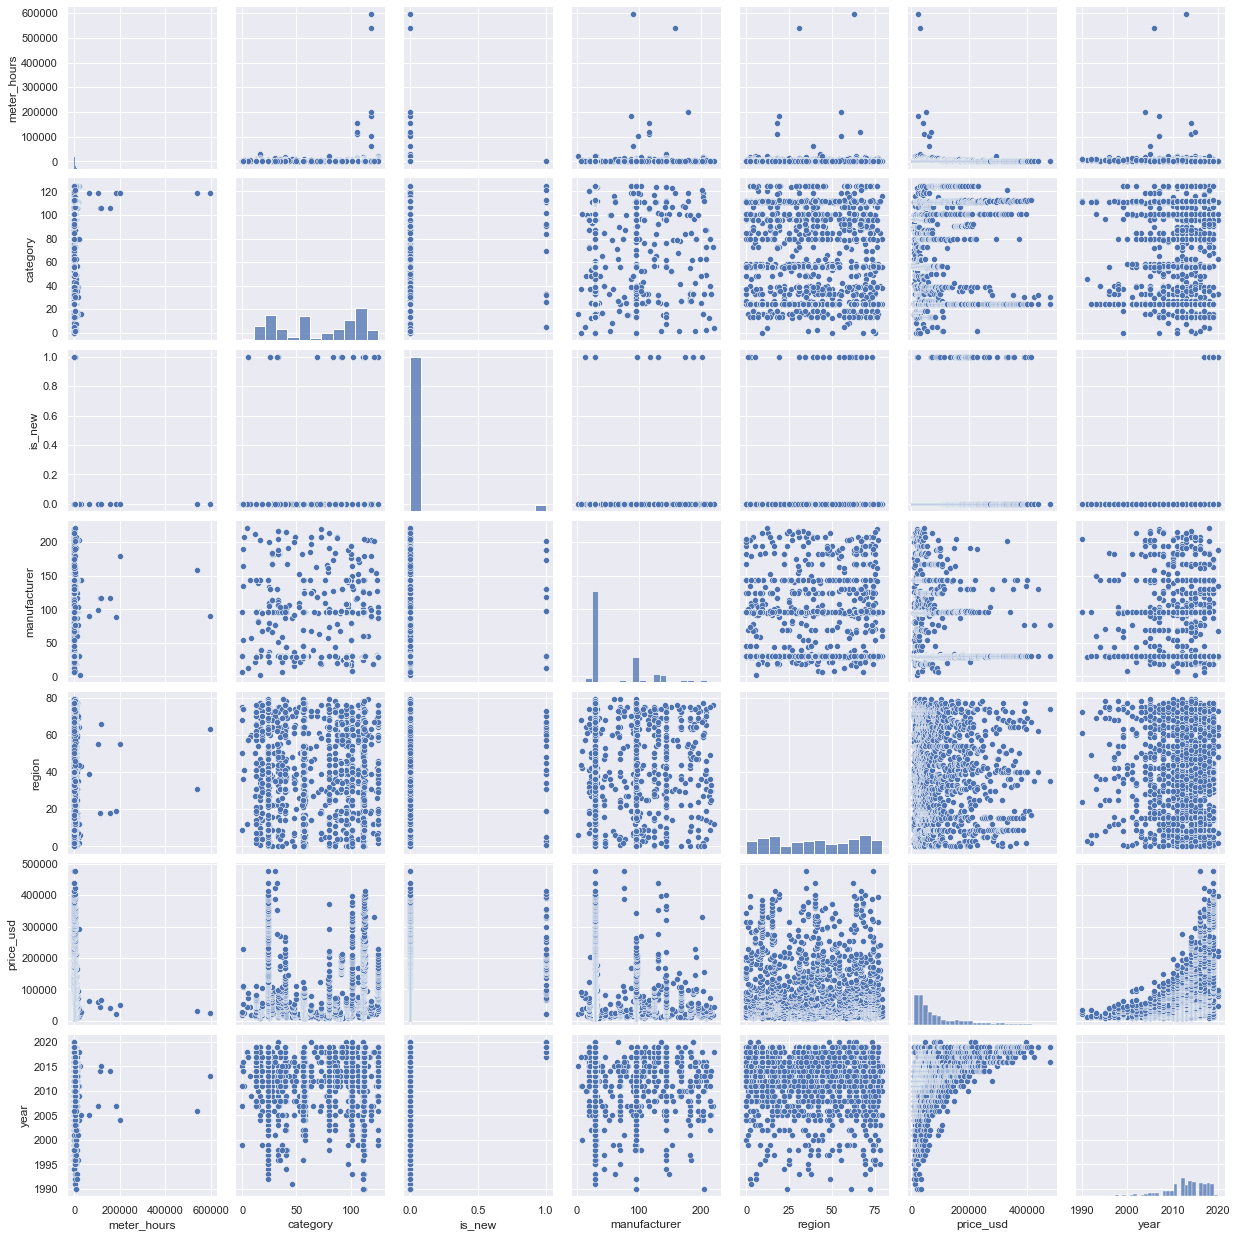

In [12]:
# Melihat persebaran data
sns.pairplot(df)

In [13]:
# Cek apakah ada data duplikasi
df.duplicated().any()

True

In [14]:
#Drop data yang terduplikasi
df.drop_duplicates(inplace=True)

E:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
E:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
E:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings

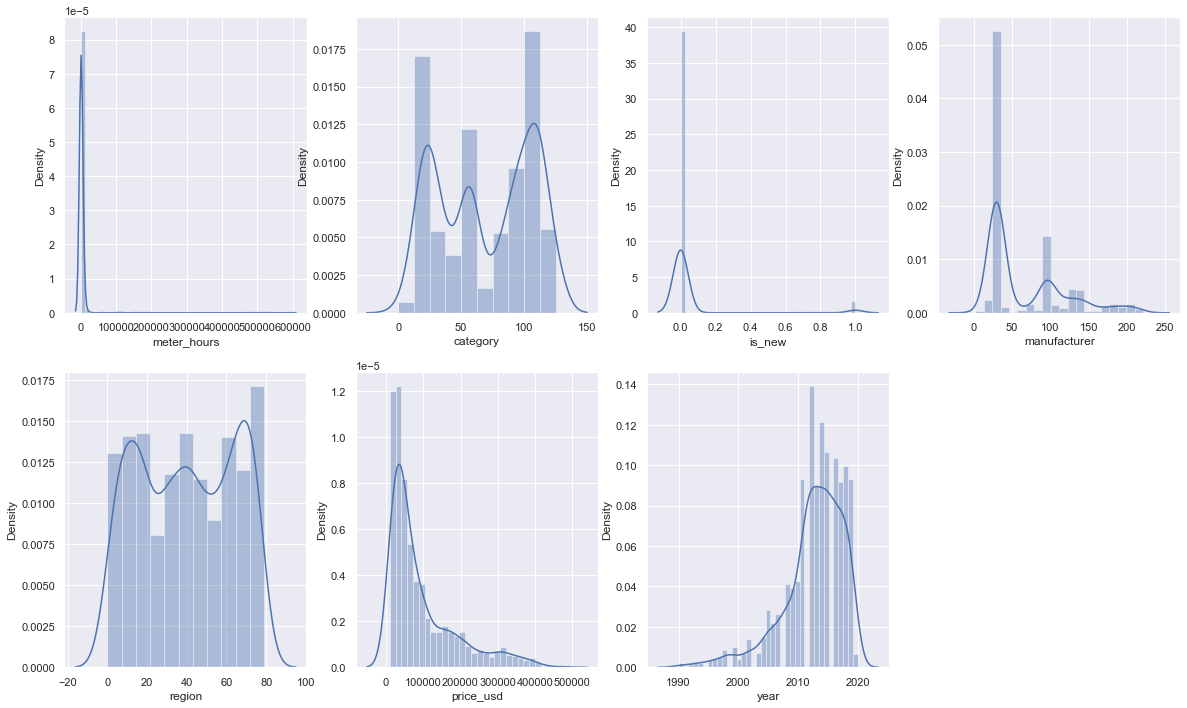

In [15]:
# Melihat Distribusi Normal dari tiap fitur
plt.figure(figsize = (20, 25))
feature_num = 1
for i in df:
    if feature_num < 13:
        ax = plt.subplot(4, 4, feature_num)
        sns.distplot(df[i])
        plt.xlabel(i, fontsize = 12)
        
    feature_num += 1
plt.show()

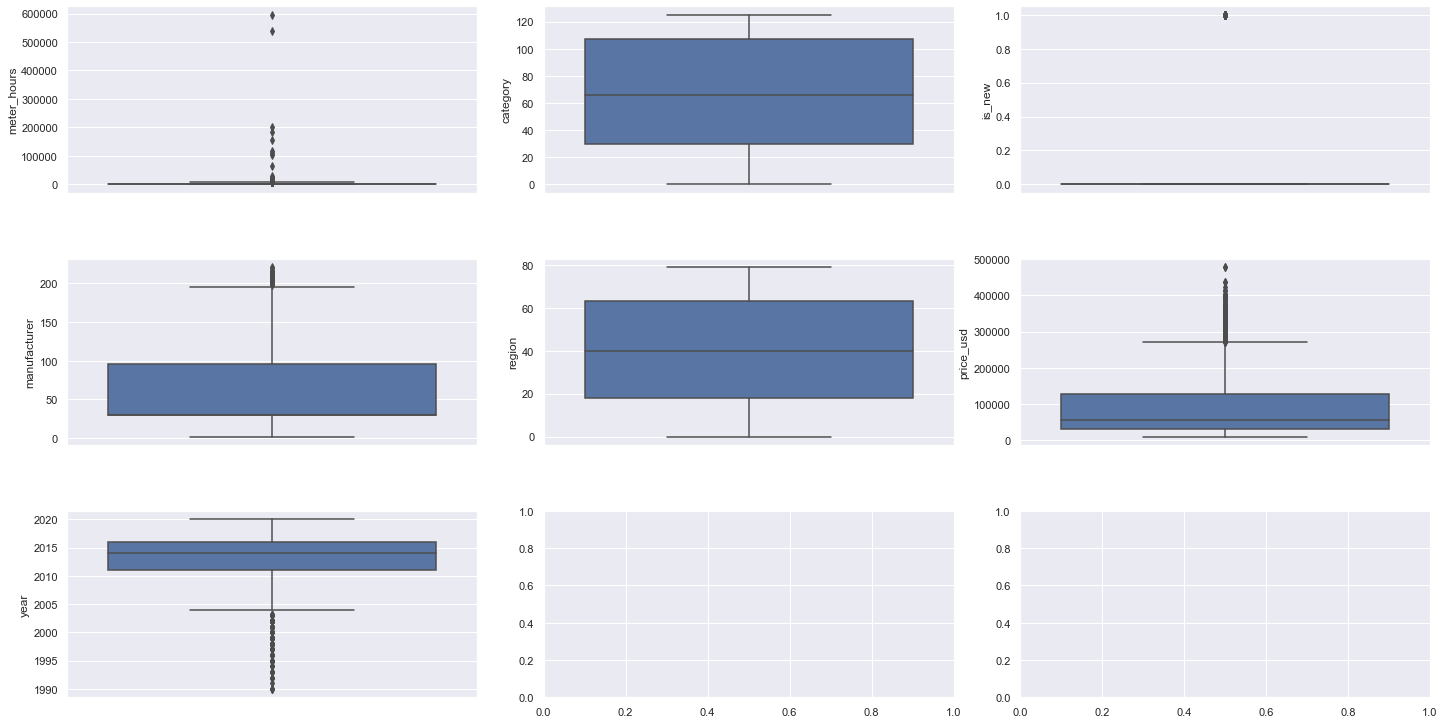

In [16]:
# Melihat apakah ada data outlier
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20,10))
index = 0
axs = axs.flatten()
for k,v in df.items():
    sns.boxplot(y=k, data=df, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [17]:
df[df['meter_hours'] == 0]

,meter_hours,category,is_new,manufacturer,region,price_usd,year
0,0,80,0,96,38,10000,1998
2,0,56,0,30,33,10100,2002
5,0,56,0,30,16,10200,2001
6,0,58,0,30,36,10200,2004
7,0,58,0,30,54,10200,2005
...,...,...,...,...,...,...,...
1554,0,80,0,30,9,222700,2017
1612,0,101,0,30,30,270700,2016
1627,0,101,0,30,30,288200,2018
1712,0,24,0,30,64,369700,2018


In [18]:
# Melihat korelasi semua fitur dengan fitur is_new
corr_matrix = df.corr()
corr_matrix["is_new"].sort_values(ascending=False)

is_new          1.000000
year            0.239938
price_usd       0.213702
category        0.119449
manufacturer    0.072599
region          0.024799
meter_hours    -0.026974
Name: is_new, dtype: float64

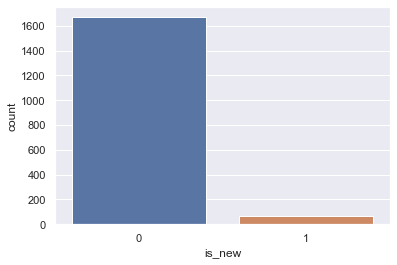

In [19]:
# Melihat keseimbangan di fitur is_new
sns.countplot(x='is_new' , data = df)

## Machine Learning Classification

In [20]:
# Import yang dibutuhkan
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score

In [21]:
# Membagi data menjadi X dan y
X = df.drop(columns='is_new')
y = df['is_new']

In [22]:
# Split data X dan y menjadi data training dan data testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [23]:
# Mengatasi Imbalanced pada kolom label
from imblearn.over_sampling import SMOTE

print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
sm = SMOTE(random_state = 5) 
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train) #transform to SM (SMOTE)
 
print('After OverSampling, the shape of x1_train_sm: {}'.format(X_train_sm.shape)) 
print('After OverSampling, the shape of y1_train_sm: {} \n'.format(y_train_sm.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_sm == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_sm == 0)))

Before OverSampling, counts of label '1': 51
Before OverSampling, counts of label '0': 1251 

After OverSampling, the shape of x1_train_sm: (2502, 6)
After OverSampling, the shape of y1_train_sm: (2502,) 

After OverSampling, counts of label '1': 1251
After OverSampling, counts of label '0': 1251


## XGBOOST Classifier

In [24]:
from xgboost import XGBRFClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
xgb_fit = XGBRFClassifier(random_state=42).fit(X_train_sm, y_train_sm)

pred_xgb = xgb_fit.predict(X_test)

E:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:00:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


E:\Anaconda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      0.97      0.98       418
           1       0.52      0.88      0.65        17

    accuracy                           0.96       435
   macro avg       0.76      0.92      0.82       435
weighted avg       0.98      0.96      0.97       435



E:\Anaconda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


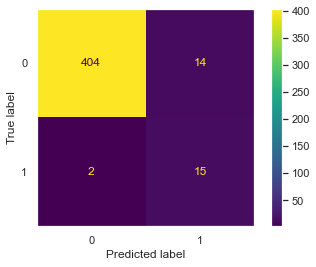

In [25]:
print(classification_report(y_test, pred_xgb))

plot_confusion_matrix(estimator=xgb_fit, X = X_test, y_true = y_test, values_format = '');
plt.grid(False)

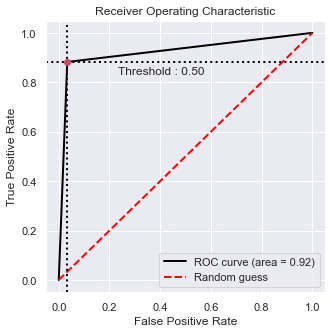

In [26]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_test, pred_xgb, labels=["Class 0", "Class 1"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

In [27]:
# import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
# models
rf = RandomForestClassifier(random_state=42)
svm = SVC(random_state=42)
lr = LogisticRegression(random_state=42)
dt = DecisionTreeClassifier(random_state=42)
knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
nb = GaussianNB()
# modeling
models = [rf, svm, lr, dt, knn, nb]

for model in models:
    model.fit(X_train_sm, y_train_sm)

E:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
# Evaluation
ypred_rf = rf.predict(X_test)
ypred_svm = svm.predict(X_test)
ypred_lr = lr.predict(X_test)
ypred_dt = dt.predict(X_test)
ypred_knn = knn.predict(X_test)
ypred_nb = nb.predict(X_test)

## Random Forest Classifier

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       418
           1       0.80      0.94      0.86        17

    accuracy                           0.99       435
   macro avg       0.90      0.97      0.93       435
weighted avg       0.99      0.99      0.99       435



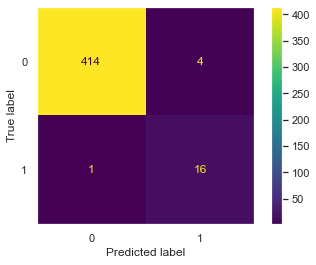

In [29]:
print(classification_report(y_test, ypred_rf))
plot_confusion_matrix(estimator=rf, X = X_test, y_true = y_test, values_format = '');
plt.grid(False)

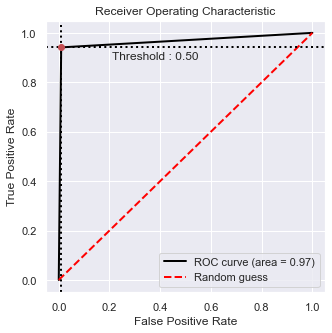

In [30]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_test, ypred_rf, labels=["Class 0", "Class 1"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

In [31]:
# What features contribute the most?
features_importances = pd.DataFrame({'Features': X_train_sm.columns, 
                                     'Score':rf.feature_importances_}).sort_values(by = 'Score', ascending = False)
features_importances.head()

,Features,Score
5,year,0.413481
4,price_usd,0.230910
0,meter_hours,0.126463
1,category,0.119739
2,manufacturer,0.063262


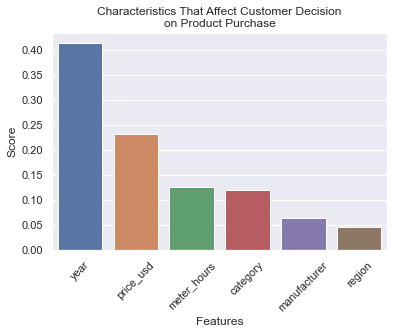

In [32]:
sns.barplot(x = 'Features', y ='Score', data = features_importances[:10]);
plt.xticks(rotation = 45)
plt.title('Characteristics That Affect Customer Decision\non Product Purchase');

## Support Vector Classifier

              precision    recall  f1-score   support

           0       0.99      0.77      0.87       418
           1       0.12      0.76      0.21        17

    accuracy                           0.77       435
   macro avg       0.55      0.77      0.54       435
weighted avg       0.95      0.77      0.84       435



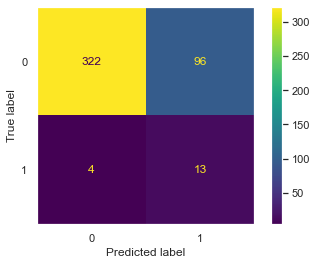

In [33]:
print(classification_report(y_test, ypred_svm))
plot_confusion_matrix(estimator=svm, X = X_test, y_true = y_test, values_format = '');
plt.grid(False)

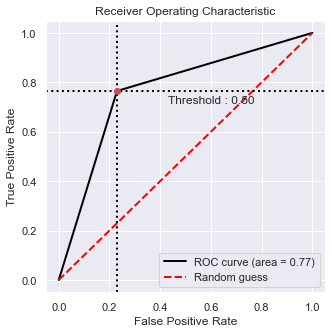

In [34]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_test, ypred_svm, labels=["Class 0", "Class 1"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

## Logistic Regression

              precision    recall  f1-score   support

           0       0.99      0.87      0.93       418
           1       0.21      0.82      0.33        17

    accuracy                           0.87       435
   macro avg       0.60      0.85      0.63       435
weighted avg       0.96      0.87      0.91       435



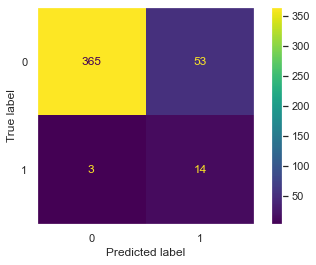

In [35]:
print(classification_report(y_test, ypred_lr))
plot_confusion_matrix(estimator=lr, X = X_test, y_true = y_test, values_format = '');
plt.grid(False)

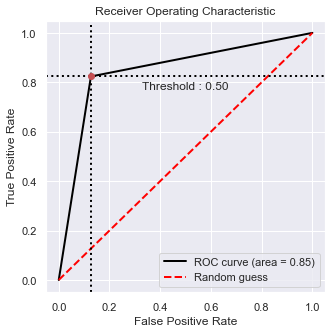

In [36]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_test, ypred_lr, labels=["Class 0", "Class 1"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

## Decision Tree Classifier

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       418
           1       0.60      0.88      0.71        17

    accuracy                           0.97       435
   macro avg       0.80      0.93      0.85       435
weighted avg       0.98      0.97      0.97       435



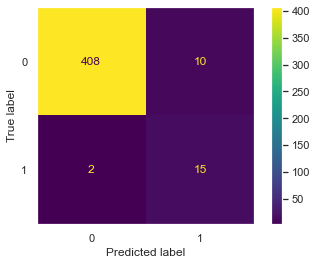

In [37]:
print(classification_report(y_test, ypred_dt))
plot_confusion_matrix(estimator=dt, X = X_test, y_true = y_test, values_format = '');
plt.grid(False)

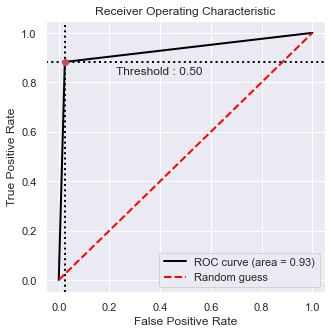

In [38]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_test, ypred_dt, labels=["Class 0", "Class 1"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

In [39]:
# What features contribute the most?
features_importances = pd.DataFrame({'Features': X_train_sm.columns, 'Score':dt.feature_importances_}).sort_values(by = 'Score', ascending = False)
features_importances.head()

,Features,Score
5,year,0.737674
0,meter_hours,0.064109
4,price_usd,0.061980
1,category,0.059041
3,region,0.052220


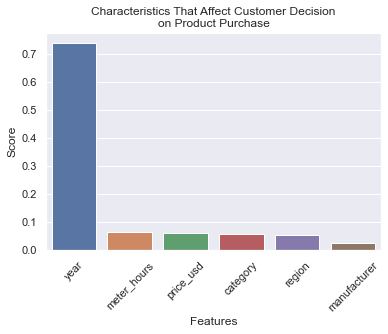

In [40]:
sns.barplot(x = 'Features', y ='Score', data = features_importances[:10]);
plt.xticks(rotation = 45)
plt.title('Characteristics That Affect Customer Decision\non Product Purchase');

## K-Nearest Neighbour

              precision    recall  f1-score   support

           0       0.99      0.87      0.93       418
           1       0.21      0.82      0.33        17

    accuracy                           0.87       435
   macro avg       0.60      0.85      0.63       435
weighted avg       0.96      0.87      0.90       435



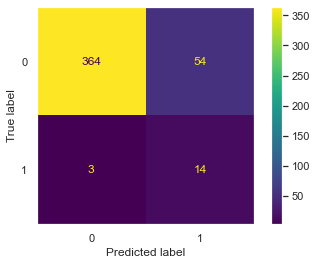

In [41]:
print(classification_report(y_test, ypred_knn))
plot_confusion_matrix(estimator=knn, X = X_test, y_true = y_test, values_format = '');
plt.grid(False)

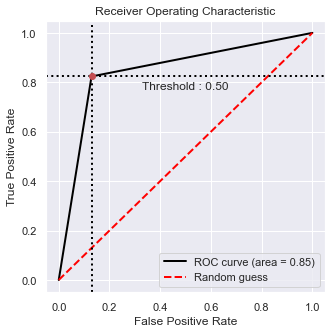

In [42]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_test, ypred_knn, labels=["Class 0", "Class 1"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

## Naive Bayes

              precision    recall  f1-score   support

           0       1.00      0.64      0.78       418
           1       0.10      0.94      0.18        17

    accuracy                           0.66       435
   macro avg       0.55      0.79      0.48       435
weighted avg       0.96      0.66      0.76       435



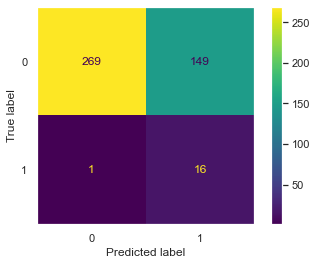

In [43]:
print(classification_report(y_test, ypred_nb))
plot_confusion_matrix(estimator=nb, X = X_test, y_true = y_test, values_format = '');
plt.grid(False)

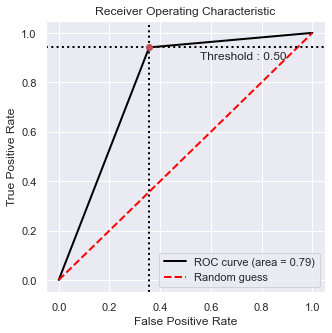

In [44]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_test, ypred_nb, labels=["Class 0", "Class 1"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

## Hyperparameter Tuning

In [45]:
model_params = {
    'svm': {
        'model': SVC(),
        'params' : {
            'C' : [1.0, 2.0, 4.0, 6.0, 8.0, 10.0],
            'kernel': ['rbf'],
            'gamma' : ['scale', 'auto']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [i for i in range(1,100,5)],
            'criterion' : ['gini', 'entropy'],
            'max_features' : ['auto', 'sqrt', 'log2'],
            'n_jobs' : [-1]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(),
        'params': {
            'C': [1.0, 2.0, 4.0, 6.0, 8.0, 10.0],
            'penalty' : ['l1', 'l2', 'elasticnet'],
            'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'multi_class' : ['auto', 'ovr', 'multinomial'],
            'n_jobs' : [-1]
        }
    }
}

In [47]:
#import gridsearch
from sklearn.model_selection import GridSearchCV
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train_sm, y_train_sm)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df_params = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_params

E:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "E:\Anaconda\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "E:\Anaconda\lib\site-packages\sklearn\base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "E:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 630, in predict
    proba = self.predict_proba(X)
  File "E:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 683, in predict_proba
    Parallel(n_jobs=n_jobs, verbose=self.verbose,
  File "E:\Anaconda\lib\site-packages\joblib\parallel.py", line 

,model,best_score,best_params
0,svm,0.835337,"{'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}"
1,random_forest,0.995603,"{'criterion': 'gini', 'max_features': 'auto', ..."
2,logistic_regression,0.929653,"{'C': 4.0, 'multi_class': 'auto', 'n_jobs': -1..."


In [ ]:
df_params

In [48]:
df_params['best_params'][1]

{'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 11, 'n_jobs': -1}

In [49]:
model2 = RandomForestClassifier(criterion='gini', max_features='auto', n_estimators =11, n_jobs= -1)

In [50]:
model2.fit(X_train_sm, y_train_sm)

RandomForestClassifier(n_estimators=11, n_jobs=-1)

In [51]:
y_test_pred_model2 = model2.predict(X_test)
y_train_pred_model2 =model2.predict(X_train_sm)

from sklearn.metrics import accuracy_score
modelsvc_acc=accuracy_score(y_test_pred_model2,y_test)

print("Train Set Accuracy:"+str(accuracy_score(y_train_pred_model2,y_train_sm)*100))
print("Test Set Accuracy:"+str(accuracy_score(y_test_pred_model2,y_test)*100))
print("\nConfusion Matrix:\n%s"%confusion_matrix(y_test_pred_model2,y_test))
print("\nClassification Report:\n%s"%classification_report(y_test_pred_model2,y_test))

Train Set Accuracy:100.0
Test Set Accuracy:97.93103448275862

Confusion Matrix:
[[410   1]
 [  8  16]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       411
           1       0.94      0.67      0.78        24

    accuracy                           0.98       435
   macro avg       0.96      0.83      0.88       435
weighted avg       0.98      0.98      0.98       435



              precision    recall  f1-score   support

           0       1.00      0.98      0.99       418
           1       0.67      0.94      0.78        17

    accuracy                           0.98       435
   macro avg       0.83      0.96      0.88       435
weighted avg       0.98      0.98      0.98       435



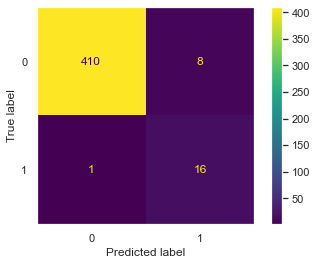

In [52]:
# Dengan Hyperparameter Tuning
print(classification_report(y_test, y_test_pred_model2))
plot_confusion_matrix(estimator=model2, X = X_test, y_true = y_test, values_format = '');
plt.grid(False)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       418
           1       0.80      0.94      0.86        17

    accuracy                           0.99       435
   macro avg       0.90      0.97      0.93       435
weighted avg       0.99      0.99      0.99       435



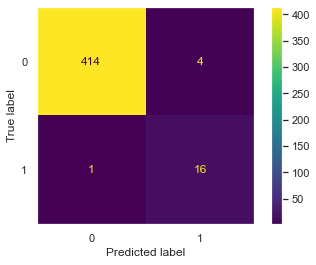

In [53]:
# Tanpa Hyperparameter Tuning
print(classification_report(y_test, ypred_rf))
plot_confusion_matrix(estimator=rf, X = X_test, y_true = y_test, values_format = '');
plt.grid(False)

### Kesimpulan
Berdasarkan dari berbagai model yang digunakan, Hasil terbaik yang bisa digunakan adalah dengan menggunakan Random Forest Classifier tanpa hyperparameter tuning

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       418
           1       0.80      0.94      0.86        17

    accuracy                           0.99       435
   macro avg       0.90      0.97      0.93       435
weighted avg       0.99      0.99      0.99       435



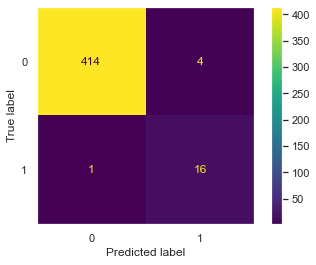

In [46]:
# Tanpa Hyperparameter Tuning
print(classification_report(y_test, ypred_rf))
plot_confusion_matrix(estimator=rf, X = X_test, y_true = y_test, values_format = '');
plt.grid(False)

In [47]:
# What features contribute the most?
features_importances = pd.DataFrame({'Features': X_train_sm.columns, 
                                     'Score':rf.feature_importances_}).sort_values(by = 'Score', ascending = False)
features_importances.head()

,Features,Score
5,year,0.413481
4,price_usd,0.230910
0,meter_hours,0.126463
1,category,0.119739
2,manufacturer,0.063262


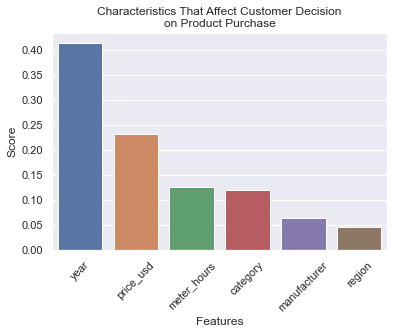

In [48]:
sns.barplot(x = 'Features', y ='Score', data = features_importances[:10]);
plt.xticks(rotation = 45)
plt.title('Characteristics That Affect Customer Decision\non Product Purchase');

## Machine Learning Regression

Dalam Machine Learning Regression ini, saya akan mencoba dengan 3 model, yaitu :

1) Multi Linear Regression

2) Random Forest Regression

3) XGBOOST Regression

## Multi Linear Regression

In [134]:
# Import Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [135]:
#Membuat X dan y
X_mlr_2 = df.drop(columns='price_usd')
y_mlr_2 = df[['price_usd']]

In [136]:
# Splitting Data Training Set dan Testing Set
X_train, X_test, y_train, y_test = train_test_split(X_mlr_2, y_mlr_2, test_size=0.2, random_state=42)

In [137]:
print(y_train.shape)
print(y_test.shape)

(1389, 1)
(348, 1)


In [53]:
import statsmodels.api as sm
from sklearn import datasets
X_train2 = sm.add_constant(X_train)
X_test2 = sm.add_constant(X_test)

# Fit and make the predictions by the model
mlr = sm.OLS(y_train, X_train2).fit() # Ordinary least squares
predictions = mlr.predict(X_test2)

# Print out the statistics
mlr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_usd   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     93.63
Date:                Sat, 17 Jul 2021   Prob (F-statistic):           8.78e-99
Time:                        13:01:21   Log-Likelihood:                -17604.
No. Observations:                1389   AIC:                         3.522e+04
Df Residuals:                    1382   BIC:                         3.526e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.585e+07   8.49e+05    -18.661      0.000   -1.75e+07   -1.42e+07
meter_hours     -0.0815      0.117     -0.697      0.486      -0.311       0.148
category        34.0409     56.921      0.598      0.550     -77.619     145.701
is_new        5.324e+04   1.09e+04      4.899      0.000    3.19e+04    7.46e+04
manufacturer  -371.8227     40.853     -9.102      0.000    -451.963    -291.683
region         -65.6735     88.243     -0.744      0.457    -238.778     107.431
year          7934.7575    421.951     18.805      0.000    7107.024    8762.491
==============================================================================
Omnibus:                      249.894   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              420.482
Skew:                           1.155   Prob(JB):                     4.94e-92
Kurtosis:                       4.390   Cond. No.                     7.39e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.39e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [54]:
X_mlr_2 = pd.DataFrame(X_mlr_2)

In [55]:
# Drop fitur category, region dan meter_hours
X_mlr_2 = X_mlr_2.drop(columns=['meter_hours', 'category', 'region'])

In [56]:
X_mlr_2

,is_new,manufacturer,year
0,0,96,1998
1,0,108,2010
2,0,30,2002
3,0,95,2011
4,0,208,2011
...,...,...,...
1737,0,76,2017
1738,0,131,2019
1739,0,30,2019
1740,0,30,2019


In [57]:
# Splitting Data Training Set dan Testing Set
X_train, X_test, y_train, y_test = train_test_split(X_mlr_2, y_mlr_2, test_size=0.2, random_state=42)

In [138]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train) # Training step

LinearRegression()

In [139]:
print('intercept:', model_lr.intercept_[0])
print('b1:',model_lr.coef_[0][0]) # is_new
print('b2:',model_lr.coef_[0][1]) # manufacturer
print('b3:',model_lr.coef_[0][2]) # year

intercept: -15851881.452204872
b1: -0.08153853201673598
b2: 34.040898925489046
b3: 53242.23979450031


In [140]:
# Melihat hasil metric
y_pred_mlr_2 = model_lr.predict(X_test)
print('MSE :', metrics.mean_squared_error(y_test, y_pred_mlr_2))
print('RMSE :', np.sqrt(metrics.mean_squared_error(y_test, y_pred_mlr_2)))
print('MAE :', metrics.mean_absolute_error(y_test, y_pred_mlr_2))
print('R^2 :', model_lr.score(X_test,y_test))
acc_mlr2 = model_lr.score(X_test, y_test)

MSE : 6151118612.955279
RMSE : 78429.06739822474
MAE : 61215.32267002687
R^2 : 0.2896027711739325


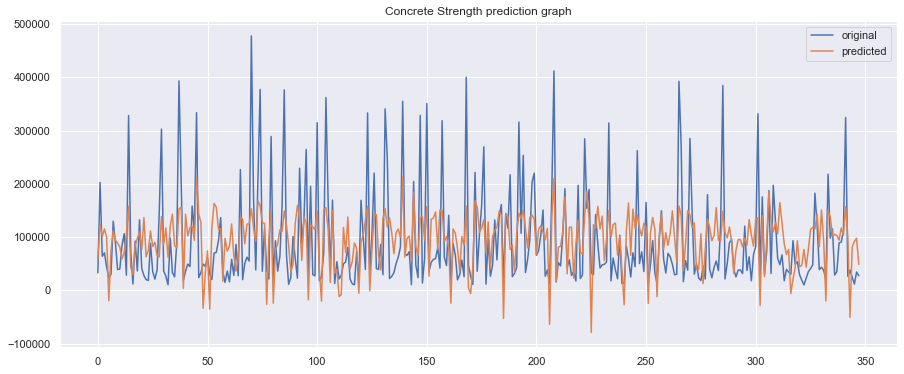

In [141]:
# Melihat hasil perbandingan actual dengan prediksi
plt.figure(figsize=(15,6))

x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred_mlr_2, label="predicted")
plt.title("Concrete Strength prediction graph")
plt.legend()
plt.show()

## Random Forest Regression

In [143]:
# Membuat X dan y
X_rf = df.drop(columns=['price_usd'])
y_rf = df[['price_usd']]

In [144]:
#Split data ke training dan testing
X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

In [145]:
# Import Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Regressor
reg = RandomForestRegressor()

# Train the model using the training sets 
reg.fit(X_train, y_train)

<ipython-input-145-42db2652d05a>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X_train, y_train)


RandomForestRegressor()

In [146]:
# Model prediction on train data
y_pred_rfg = reg.predict(X_train)

In [147]:
# Model Evaluation Training
print('R^2:',metrics.r2_score(y_train, y_pred_rfg))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred_rfg))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred_rfg))
print('MSE:',metrics.mean_squared_error(y_train, y_pred_rfg))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred_rfg)))

R^2: 0.9730259804192986
Adjusted R^2: 0.9729088717959381
MAE: 8600.477870320823
MSE: 226571147.01983798
RMSE: 15052.280459114425


In [148]:
compare_rfg = y_test.reset_index(drop = True).join(pd.DataFrame(y_pred_rfg, columns=['Prediction']))
#compare_mlr['Residuals'] = compare_mlr['price_usd']-compare_mlr['Prediction']
compare_rfg.head(20)

,price_usd,Prediction
0,32900,36311.000000
1,202700,14993.000000
2,64100,15475.000000
3,70500,22288.000000
4,43500,117665.000000
5,23200,13136.000000
6,30700,54271.000000
7,129900,18912.000000
8,89700,27608.000000
9,39200,378150.000000


In [149]:
#Cek autokorelasi
from statsmodels.stats.stattools import durbin_watson
durbinWatson = durbin_watson(compare_rfg['price_usd']-compare_rfg['Prediction'])
print('Durbin-Watson:', durbinWatson)
if durbinWatson < 1.5:
    print('Signs of positive autocorrelation', '\n')
    print('Assumption not satisfied')
elif durbinWatson > 2.5:
    print('Signs of negative autocorrelation', '\n')
    print('Assumption not satisfied')
else:
    print('Little to no autocorrelation', '\n')
    print('Assumption satisfied')

Durbin-Watson: 2.0346874182291725
Little to no autocorrelation 

Assumption satisfied


Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 8.44653568869269e-12
Residuals are not normally distributed


E:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


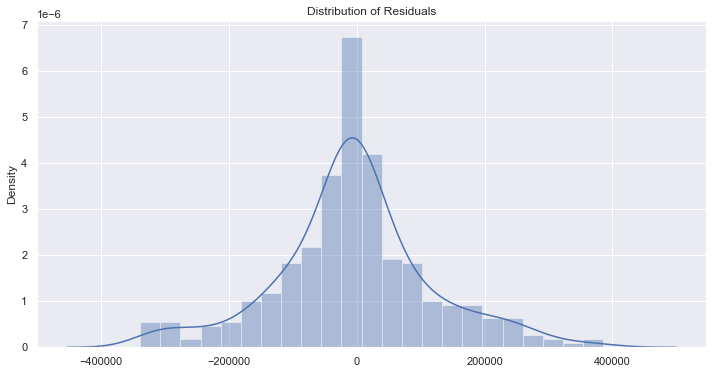


Assumption not satisfied


In [150]:
# Cek normalitas
from statsmodels.stats.diagnostic import normal_ad

print('Using the Anderson-Darling test for normal distribution')

# Performing the test on the residuals
p_value = normal_ad(compare_rfg['price_usd']-compare_rfg['Prediction'])[1]
print('p-value from the test - below 0.05 generally means non-normal:', p_value)

# Reporting the normality of the residuals
if p_value < 0.05:
    print('Residuals are not normally distributed')
else:
    print('Residuals are normally distributed')

# Plotting the residuals distribution
plt.subplots(figsize=(12, 6))
plt.title('Distribution of Residuals')
sns.distplot(compare_rfg['price_usd']-compare_rfg['Prediction'])
plt.show()

print()
if p_value > 0.05:
    print('Assumption satisfied')
else:
    print('Assumption not satisfied')

In [151]:
# Prediksi tes data dengan model
y_test_pred_rfg = reg.predict(X_test)

In [152]:
# Model Evaluation Testing
acc_rf = metrics.r2_score(y_test, y_test_pred_rfg)
print('R^2:', acc_rf)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred_rfg))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_test_pred_rfg))
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred_rfg))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_rfg)))
rmse_rf = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_rfg))

R^2: 0.8922658295936181
Adjusted R^2: 0.8903702136920395
MAE: 18262.84931887238
MSE: 932838183.9736063
RMSE: 30542.399774307294


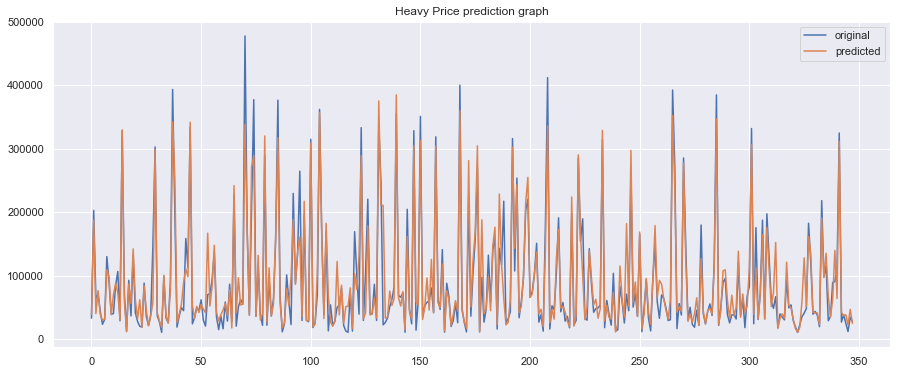

In [153]:
plt.figure(figsize=(15,6))

x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_test_pred_rfg, label="predicted")
plt.title("Heavy Price prediction graph")
plt.legend()
plt.show()

## XGBOOST Regressor

In [154]:
# Import XGBoost Regressor
from xgboost import XGBRegressor

#Create a XGBoost Regressor
xbreg = XGBRegressor()

# Train the model using the training sets 
xbreg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [155]:
# Model prediction on train data
y_pred_xg = xbreg.predict(X_train)

E:\Anaconda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [156]:
# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred_xg))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred_xg))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred_xg))
print('MSE:',metrics.mean_squared_error(y_train, y_pred_xg))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred_xg)))

R^2: 0.9959193877264689
Adjusted R^2: 0.9959016716095072
MAE: 3982.8673864684574
MSE: 34275536.89545926
RMSE: 5854.531313047976


In [157]:
# What features contribute the most?
features_importances = pd.DataFrame({'Features': X_train.columns, 
                                     'Score':xbreg.feature_importances_}).sort_values(by = 'Score', ascending = False)
features_importances.head()

,Features,Score
5,year,0.362410
3,manufacturer,0.251601
1,category,0.194804
2,is_new,0.129138
0,meter_hours,0.045100


In [158]:
compare_xg = y_test.reset_index(drop = True).join(pd.DataFrame(y_pred_xg, columns=['Prediction']))
#compare_mlr['Residuals'] = compare_mlr['price_usd']-compare_mlr['Prediction']
compare_xg.head(20)

,price_usd,Prediction
0,32900,38017.281250
1,202700,13179.247070
2,64100,14898.332031
3,70500,24738.421875
4,43500,116714.085938
5,23200,9209.052734
6,30700,46725.937500
7,129900,14962.673828
8,89700,25481.388672
9,39200,383670.906250


In [159]:
#Cek autokorelasi
from statsmodels.stats.stattools import durbin_watson
durbinWatson = durbin_watson(compare_xg['price_usd']-compare_xg['Prediction'])
print('Durbin-Watson:', durbinWatson)
if durbinWatson < 1.5:
    print('Signs of positive autocorrelation', '\n')
    print('Assumption not satisfied')
elif durbinWatson > 2.5:
    print('Signs of negative autocorrelation', '\n')
    print('Assumption not satisfied')
else:
    print('Little to no autocorrelation', '\n')
    print('Assumption satisfied')

Durbin-Watson: 2.061698612539739
Little to no autocorrelation 

Assumption satisfied


Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 3.218799238641516e-12
Residuals are not normally distributed


E:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


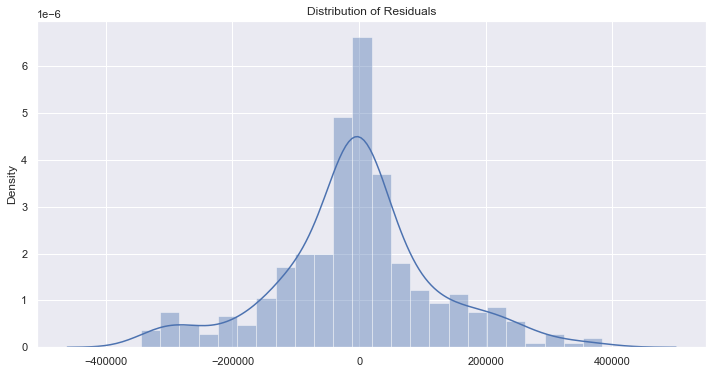


Assumption not satisfied


In [160]:
# Cek normalitas
from statsmodels.stats.diagnostic import normal_ad

print('Using the Anderson-Darling test for normal distribution')

# Performing the test on the residuals
p_value = normal_ad(compare_xg['price_usd']-compare_xg['Prediction'])[1]
print('p-value from the test - below 0.05 generally means non-normal:', p_value)

# Reporting the normality of the residuals
if p_value < 0.05:
    print('Residuals are not normally distributed')
else:
    print('Residuals are normally distributed')

# Plotting the residuals distribution
plt.subplots(figsize=(12, 6))
plt.title('Distribution of Residuals')
sns.distplot(compare_xg['price_usd']-compare_xg['Prediction'])
plt.show()

print()
if p_value > 0.05:
    print('Assumption satisfied')
else:
    print('Assumption not satisfied')

In [161]:
# Prediksi tes data dengan model
y_test_pred_xg = xbreg.predict(X_test)

E:\Anaconda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [162]:
# Model Evaluation
acc_xgb = metrics.r2_score(y_test, y_test_pred_xg)
print('R^2:', acc_xgb)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred_xg))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_test_pred_xg))
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred_xg))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_xg)))
rmse_xgb = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_xg))

R^2: 0.8951800160918789
Adjusted R^2: 0.8933356761990674
MAE: 18526.335616539265
MSE: 907605108.6128018
RMSE: 30126.485168582174


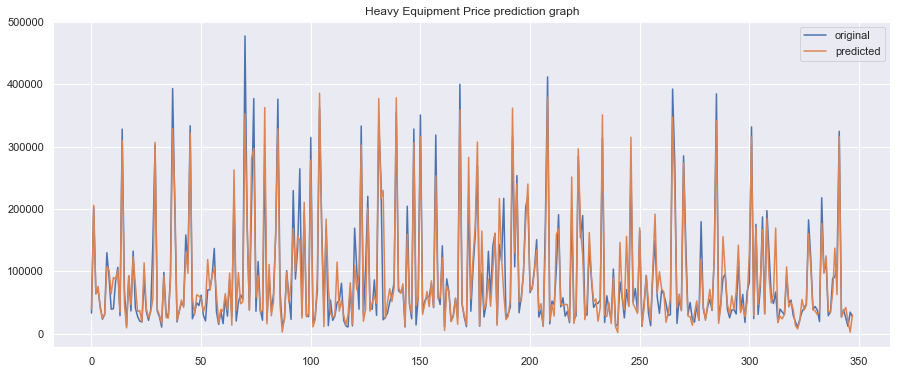

In [163]:
plt.figure(figsize=(15,6))

x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_test_pred_xg, label="predicted")
plt.title("Heavy Equipment Price prediction graph")
plt.legend()
plt.show()

In [164]:
# Membandingkan hasil dari modelling yang sudah dilakukan dari R^2 Score
models = pd.DataFrame({
    'Model': ['Multi Linear Regression', 'Random Forest', 'XGBoost'],
    'R-squared Score': [acc_mlr2*100, acc_rf*100, acc_xgb*100]})
models.sort_values(by='R-squared Score', ascending=False)

,Model,R-squared Score
2,XGBoost,89.518002
1,Random Forest,89.226583
0,Multi Linear Regression,28.960277


In [165]:
# Membandingkan hasil dari modelling yang sudah dilakukan dengan RMSE
models = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'RMSE Score': [rmse_rf, rmse_xgb]})
models.sort_values(by='RMSE Score', ascending=False)

,Model,RMSE Score
0,Random Forest,30542.399774
1,XGBoost,30126.485169


### Hyperparameter Tuning

In [166]:
from sklearn.model_selection import cross_val_score, GridSearchCV
model = XGBRegressor(n_jobs=4)

parameters = {
    'n_estimators': [50, 100, 500],
    'max_depth': [2, 4, 6, 8, 10],
    'gamma': [0.001, 0.01],
    'learning_rate': [0.01, 0.1],
    'booster': ['gbtree']
}

grid_obj = GridSearchCV(
    estimator=xbreg,
    param_grid=parameters
)

grid_obj.fit(X_train, y_train)

best_model = grid_obj.best_estimator_
print(best_model)

E:\Anaconda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
E:\Anaconda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
E:\Anaconda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
E:\Anaconda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
E:\Anaconda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=2, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


In [167]:
xgc = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=np.nan, monotone_constraints='()',
             n_estimators=500, n_jobs=2, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [168]:
# Train the model using the training sets 
xgc.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=2, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [169]:
# Model prediction on train data
y_pred_xgc = xgc.predict(X_train)

E:\Anaconda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [170]:
# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred_xgc))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred_xgc))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred_xgc))
print('MSE:',metrics.mean_squared_error(y_train, y_pred_xgc))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred_xgc)))

R^2: 0.9811083848358721
Adjusted R^2: 0.9810263662461581
MAE: 8456.180504114358
MSE: 158682131.30000612
RMSE: 12596.909593229846


In [171]:
compare_xgc = y_test.reset_index(drop = True).join(pd.DataFrame(y_pred_xgc, columns=['Prediction']))
#compare_mlr['Residuals'] = compare_mlr['price_usd']-compare_mlr['Prediction']
compare_xgc.head(20)

,price_usd,Prediction
0,32900,30600.162109
1,202700,6853.270508
2,64100,13418.020508
3,70500,25853.513672
4,43500,110787.609375
5,23200,9135.249023
6,30700,49042.542969
7,129900,12345.245117
8,89700,19197.347656
9,39200,373659.406250


In [172]:
# Prediksi tes data dengan model
y_test_pred_xgc = xgc.predict(X_test)
# Model Evaluation
acc_xgc = metrics.r2_score(y_test, y_test_pred_xgc)
print('R^2:', acc_xgc)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred_xgc))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_test_pred_xgc))
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred_xgc))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_xgc)))
rmse_xgc = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_xgc))

R^2: 0.8935271537118951
Adjusted R^2: 0.8916537311965618
MAE: 19272.338789315058
MSE: 921916753.052875
RMSE: 30363.08207433618


E:\Anaconda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


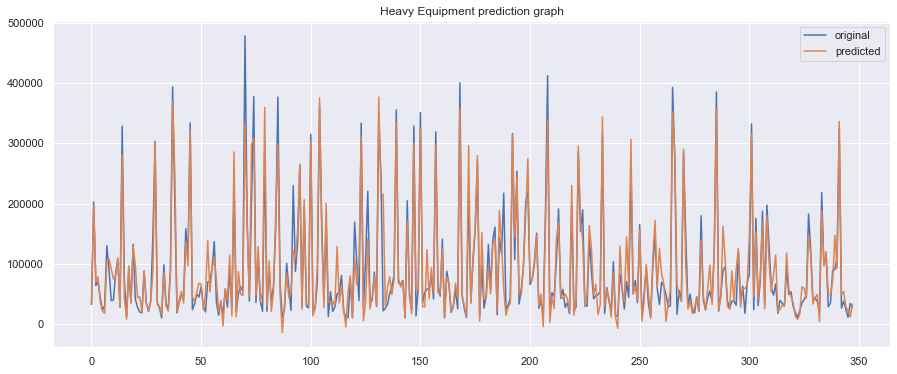

In [173]:
plt.figure(figsize=(15,6))

x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_test_pred_xgc, label="predicted")
plt.title("Heavy Equipment prediction graph")
plt.legend()
plt.show()

## Kesimpulan

Berdasarkan hasil dari 3 modelling dan juga menggunakan hyperparameter tuning, didapatkan hasil terbaik menggunakan XGBoost Regression tanpa hyperparameter tuning

### XGBOOST Regression